This project aims to classify dbpedia text using bag-of-words model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
%matplotlib inline

# 1.Fetch Text Data

Dbpedia has been downloaded. For more information, visit:http://wiki.dbpedia.org

In [2]:
path = 'dbpedia_csv/'
train_data = pd.read_csv(path+'train.csv', header=None)
test_data = pd.read_csv(path+'test.csv', header=None)
train_data.columns = ['type', 'header', 'content']
test_data.columns = ['type', 'header', 'content']
#X_train, y_train = train_data[2], train_data[0]
#X_test, y_test = test_data[2], test_data[0]

In [3]:
train_data.head()

,type,header,content
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


In [4]:
print('Training text number:', len(train_data))
print('Testing text number:', len(test_data))

Training text number: 560000
Testing text number: 70000


In [5]:
print(np.unique(train_data['type']))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Take a look at the news itself.

In [6]:
train_data.iloc[0, 2]

' Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972.'

It seems there are punctuation and digits within the texts, we can assume they play less important role in dertemining categories in this project. We only focus on words, terms, so we can remove those punctuations as well as digits.

# 2.Preprocessing

We are going to remove punctuations and digits.

In [7]:
#Map punctuations into blanks
trantab_punc = str.maketrans(string.punctuation,' '*len(string.punctuation))
trantab_digit = str.maketrans('0123456789',' '*10)
#trantab_enter = str.maketrans('\n',' ')
#shift to lower cases
#Using lambda function to simplify code
remove_punc_digit = lambda text: text.translate(trantab_punc).translate(trantab_digit).lower()
#texts = [remove_punc_digit(text).lower().strip() for text in texts]

Preprocess each piece of news.

In [8]:
train_data['cleaned_content'] = train_data['content'].map(remove_punc_digit)
test_data['cleaned_content'] = test_data['content'].map(remove_punc_digit)

In [9]:
train_data.iloc[0,3]

' abbott of farnham e d abbott limited was a british coachbuilding business based in farnham surrey trading under that name from       a major part of their output was under sub contract to motor vehicle manufacturers  their business closed in      '

Take a look at the preprocessed data.

## 3.Data Exploration

### Word Count

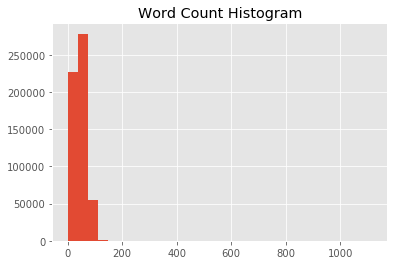

In [10]:
#Calculate the character lengths for each piece of news
#lengths =  [len(item) for item in newsgroups_train.data]
train_data['word_count'] = train_data['cleaned_content'].str.split().map(len)
plt.style.use('ggplot')
plt.hist(train_data['word_count'], bins=30)
plt.title('Word Count Histogram')

Most texts have less than 200 words.

In [11]:
train_data['words'] = train_data['cleaned_content'].str.split()
#Make a boxplot, ignore outliers
train_data['words'][0]

['abbott',
 'of',
 'farnham',
 'e',
 'd',
 'abbott',
 'limited',
 'was',
 'a',
 'british',
 'coachbuilding',
 'business',
 'based',
 'in',
 'farnham',
 'surrey',
 'trading',
 'under',
 'that',
 'name',
 'from',
 'a',
 'major',
 'part',
 'of',
 'their',
 'output',
 'was',
 'under',
 'sub',
 'contract',
 'to',
 'motor',
 'vehicle',
 'manufacturers',
 'their',
 'business',
 'closed',
 'in']

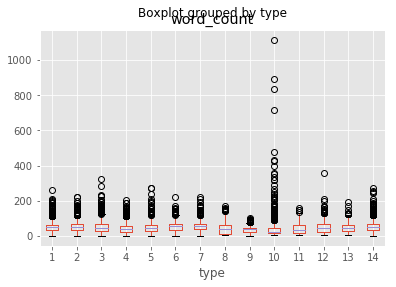

In [12]:
train_data.boxplot(column='word_count', by='type')

Type 10 has very long texts, we do not handle it initially.

In [13]:
np.percentile(train_data['word_count'], [25, 50, 95])

array([ 26.,  45.,  79.])

The majority of texts has less than 80 words.

### Word Frequency

In [14]:
#Build Vocabulary 
words = []
for text in train_data['words']:
    words.extend(text)
len(words)

25324388

There are millions of words in total.

In [15]:
from collections import Counter
word_freq = Counter(words)
len(word_freq)

660029

Actually, there are only 660029 unique words.

In [16]:
#Select 50000 most frequent words
vocab_pair = word_freq.most_common(50000)
vocab_sorted = sorted(vocab_pair, key=lambda d:d[1], reverse = True)
most_freq = vocab_sorted[:20]

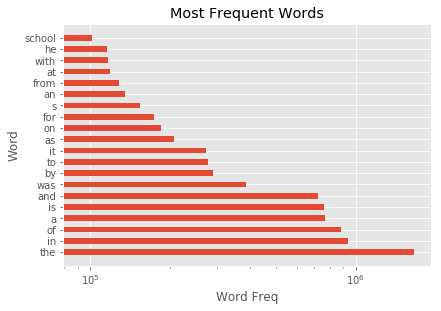

In [51]:
selected_words, freqs = list(zip(*most_freq))
plt.barh(bottom = range(20), width=freqs, height=0.5, tick_label=selected_words, log=True)
plt.tight_layout()
plt.xlabel('Word Freq')
plt.ylabel('Word')
plt.title('Most Frequent Words')

It seems most fequent words are stop words such as "and", "in", "the".

## 4.How to Represent a Text

Usually, the input of machine learning is expected to be rows of vectors, each row means a sample, and each column means a feature, whereas the texts consist of series of term symbols. Therefore, it is neccessary to transform texts into vectors.

Bag-of-word model is commonly used in text classification, first we build a vocabulary and map each text into a vector of frequencies(or TfIdf values) of words within the vocabulary. For example:
"I like this dog!"
"You like this dog too!"

The vocabulary is ['I', 'You', 'like', 'this', 'dog', 'too'].
Two sentences can be represented as:
```
[1, 0, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1]
```

In [18]:
X_train, y_train = train_data['cleaned_content'], train_data['type']
X_test, y_test = test_data['cleaned_content'], test_data['type']

### Unigram TfIdf Model

Sklearn has provided tools to extract features from data such as contexts, for example,  CountVectorizer and TfidfVectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_features=20000)
X_train_tfidf = tfidfVectorizer.fit_transform(X_train)
X_train_tfidf.shape

(560000, 20000)

In [20]:
X_test_tfidf = tfidfVectorizer.transform(X_test)
X_test_tfidf.shape

(70000, 20000)

In [21]:
X_train_tfidf.getrow(0)

<1x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [22]:
X_train_tfidf.getrow(0).toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## 5.Classification Models

We can try different classification models on the dataset. Note, this dataset has 560000 samples, relatively large, therefore, we need to take this into consideration.

### Models

Naive bayesian model is often used in text classification, although there's a strong assumption, each conditional probability of words are independent. Also, knn methods can be used to classify according to the distance of samples.

In [28]:
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=False, tol=1e-5, random_state=1,
                    learning_rate_init=.17)
nb = MultinomialNB(0.01)
lr = LogisticRegression(C=0.5, n_jobs=4, random_state=1)
rf =  RandomForestClassifier(n_jobs=4, random_state=1, max_depth=10)
#knn = KNeighborsClassifier(n_neighbors=50,weights='distance')
models = [lr, nb, rf, mlp]

We can use f1 score as the classification metrics, in addition, cross validation is considered.

In [29]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
def train(model, data, label, validation=True):
    #if not model:
        #raise ValueError('Input must not be None!')
    if validation:
        scores = cross_val_score(model, data, label, cv=5)
        print('Accuracy:', scores)
    model.fit(data, label)
    return model

It is common to use micro F1 and macro F1 values as the metrics for document classification. For more details, please refer to http://firefenix.blog.163.com/blog/static/10338509720134973556756/.

In [30]:
def test(model, data, label):
    #if not model:
        #raise ValueError('Input must not be None!')
    preds = model.predict(data)
    micro_f1 = f1_score(label, preds, average='micro')
    macro_f1 = f1_score(label, preds, average='macro')
    print('Micro F1: {:.3f}'.format(micro_f1))
    #Macro F1
    print('Macro F1: {:.3f}'.format(macro_f1))
    return micro_f1, macro_f1

In [31]:
for model in models:
    '''Train Different Models'''
    print(model.__class__)
    if model is mlp or model is rf:
        md = train(model, X_train_tfidf, y_train, False)
    else:
        md = train(model, X_train_tfidf, y_train)
    micro_f1, macro_f1 = test(md, X_test_tfidf, y_test)
    print('*'*80)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy: [ 0.97503571  0.97558929  0.97517857  0.97563393  0.9758125 ]
Micro F1: 0.976
Macro F1: 0.976
********************************************************************************
<class 'sklearn.naive_bayes.MultinomialNB'>
Accuracy: [ 0.94396429  0.94433036  0.94366964  0.94340179  0.94465179]
Micro F1: 0.945
Macro F1: 0.944
********************************************************************************
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Micro F1: 0.663
Macro F1: 0.663
********************************************************************************
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Micro F1: 0.978
Macro F1: 0.978
********************************************************************************


## 7.All-In-One Model

According to the analysis above, we are going to create a class to finish all the steps.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
#from stemming.porter2 import stem
from nltk.stem import WordNetLemmatizer
punctuations = string.punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 

In [33]:
from sklearn.decomposition import PCA
class text_classification(object):
    '''This class aims to transform preprocessed texts into TfIdf vectors
    and applies specified models to do classifications'''
    def __init__(self, train_data, train_label, ngram=1, max_features=10000):
        '''Initialize Parameters'''
        self.train_data = train_data
        self.train_label = train_label
        self.ngram = ngram
        self.max_features = max_features
        self.vectorizer = self.__build_vectorizer()
        self.model = None
        

        
    def __lem_stem(self, data):
        '''Take lemmatizer and stemmize into account'''
        lemmatizer = WordNetLemmatizer()
        lem_data = [lemmatizer.lemmatize(word.strip()) for word 
                    in data.split()]
        data = ' '.join(lem_data)
        #stem_data = [stem(word.strip()) for word 
                    #in data.split() ]
        #data = ' '.join(data)
        return data
    
    def __dimension_reduction(self, data):
        '''Reduce dimension of original data'''
        threshold = 0.9
        pca = PCA()
        pca.fit(data)
        cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
        #Select a few principal compoents whose variances accounted for 90%
        n_component = sum(cumsum_variance > threshold)
        
        
    def __build_vectorizer(self):
        '''Build vectorized based on TfIdf model'''
        #self.train_data = [self.__spacy_tokenizer(news) for news in self.train_data]
        self.train_data = [self.__lem_stem(news) for news in self.train_data]
        tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, self.ngram), 
                                          max_features=self.max_features)
        tfidfVectorizer.fit(self.train_data)
        return tfidfVectorizer
        
    def __text_transform(self, data):
        '''Transform each text into a vector of TfIdf values of terms'''
        if data is None:
            raise ValueError('Data Is Empty!')
        tfidfVectorizer = self.vectorizer
        text_tfidf = tfidfVectorizer.transform(data)
        return text_tfidf
    
    def train(self, model, validation=False):
        '''Train a model'''
        if model is None:
            raise ValueError('Model Must Be Specified!')
        train_tfidf = self.__text_transform(self.train_data)
        #Validate the performance of Classification Method
        if validation:
            scores = cross_val_score(model, train_tfidf, self.train_label, cv=5)
            print('Accuracy:', scores)
        model.fit(train_tfidf, self.train_label)
        self.model = model
        return model
    
    def test(self, test_data, test_label):
        '''Test the model after the model as been trained'''
        if self.model is None:
            raise ValueError('Model Must Be Specified!')
        test_data = [self.__lem_stem(news) for news in test_data]
        #test_data = [self.__spacy_tokenizer(news) for news in test_data]
        test_tfidf = self.__text_transform(test_data)
        preds = self.model.predict(test_tfidf)
        micro_f1 = f1_score(test_label, preds, average='micro')
        print('Micro F1: {:.3f}'.format(micro_f1))
        return micro_f1

In [35]:
#Create a model
#tc = text_classification(train_data, train_label, ngram=1, max_features=30000)
tc = text_classification(X_train, y_train, ngram=1, max_features=10000)

In [38]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=False, tol=1e-5, random_state=1,
                    learning_rate_init=.17)
nb = MultinomialNB(0.01)
lr = LogisticRegression(C=0.5, random_state=1)
rf =  RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=4, random_state=1)

In [39]:
tc.train(nb)
tc.test(X_test, y_test)
#tc.test(test_data, test_label)

Micro F1: 0.944


0.94355714285714287

### Train Different Models

In [42]:
#Train the model with several classifiers
models = [lr, rf, nb, mlp]
for model in models:
    start_time = time.time()
    print(model.__class__)
    validation = True
    if model is mlp or model is rf:
        validation = False
    tc.train(model, validation)
    tc.test(X_test, y_test)
    end_time = time.time()
    print('Time:', end_time-start_time)
    print('*'*30)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy: [ 0.97266964  0.97266071  0.97264286  0.9733125   0.97317857]
Micro F1: 0.974
Time: 190.70686888694763
******************************
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Micro F1: 0.731
Time: 43.40317225456238
******************************
<class 'sklearn.naive_bayes.MultinomialNB'>
Accuracy: [ 0.94291071  0.94372321  0.94300893  0.94275893  0.94441071]
Micro F1: 0.944
Time: 43.842857122421265
******************************
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Micro F1: 0.975
Time: 1900.653584241867
******************************


### Tune Parameters

Allowing for the test performance and timing, we select logistic regression as final model, and we can tune the C values, which means Inverse of regularization strength. The larger C is, the less regularization strength is, and the model tends to overfit.

In [44]:
from sklearn.model_selection import GridSearchCV 
parameters = {'C': [2, 1, 0.5, 0.2, 0.1, 0.05]}
lr = LogisticRegression(random_state=1)
gs = GridSearchCV(estimator=lr, param_grid=parameters, cv=5)
tc.train(gs)
tc.test(X_test, y_test)

Micro F1: 0.976


0.97608571428571433

In [53]:
gs.best_params_

{'C': 2}

In [45]:
import pandas as pd
df_result = pd.DataFrame(gs.cv_results_)

In [46]:
df_result

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,29.204807,0.057377,0.975770,0.981909,2,{'C': 2},1,0.975518,0.982011,0.975812,...,0.975196,0.981924,0.976080,0.981781,0.976241,0.981835,0.332485,0.001390,0.000378,0.000089
1,27.898088,0.060184,0.974655,0.979171,1,{'C': 1},2,0.974455,0.979279,0.974464,...,0.974366,0.979176,0.974973,0.979025,0.975018,0.979056,1.405793,0.008863,0.000280,0.000117
2,24.486884,0.064732,0.972893,0.976166,0.5,{'C': 0.5},3,0.972670,0.976335,0.972661,...,0.972643,0.976248,0.973313,0.975975,0.973179,0.976020,0.899558,0.012271,0.000291,0.000142
3,23.445327,0.060915,0.969877,0.971889,0.2,{'C': 0.2},4,0.969688,0.972007,0.969518,...,0.969598,0.971938,0.970152,0.971779,0.970429,0.971754,0.897035,0.004214,0.000353,0.000103
4,20.970330,0.057760,0.966850,0.968322,0.1,{'C': 0.1},5,0.966679,0.968313,0.966643,...,0.966402,0.968480,0.967304,0.968179,0.967223,0.968192,0.695154,0.001022,0.000352,0.000125
5,20.000297,0.057312,0.962927,0.963945,0.05,{'C': 0.05},6,0.962875,0.964033,0.962393,...,0.962589,0.964054,0.963259,0.963819,0.963518,0.963748,0.496832,0.002103,0.000415,0.000134


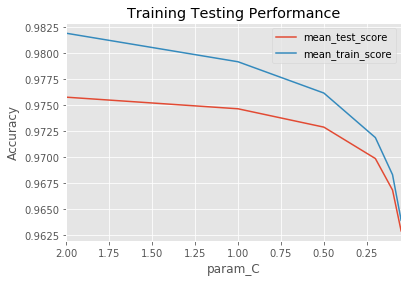

In [48]:
df_result.set_index('param_C')[['mean_test_score', 'mean_train_score']].plot()
plt.ylabel('Accuracy')
plt.title('Training Testing Performance')

The plot indicates that with the decrease of C value, the performance of the model tends to be biased, whereas the variance tends to decrease as well. Actually when C=0.5, there's a balance between bias and variance.

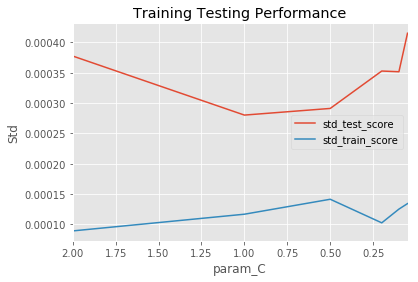

In [50]:
df_result.set_index('param_C')[['std_test_score', 'std_train_score']].plot()
plt.ylabel('Std')
plt.title('Training Testing Performance')